# Sample elevations along glacier flowline

In [68]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
import xarray as xr
import numpy as np
from tqdm.auto import tqdm
import os
import glob
from shapely.geometry import LineString

In [6]:
# root directory to all data
data_path = '/Users/raineyaberle/Research/PhD/Hubbard/'
# path for saving figures
figures_out_path = os.path.join(data_path, 'figures')

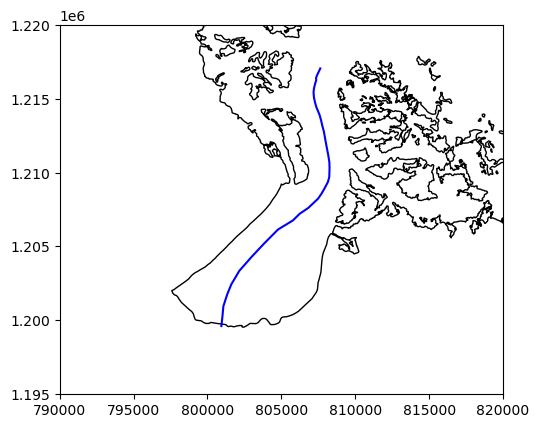

In [67]:
# -----Load glacier boundaries and flowline
# Load glacier boundaries
aoi_fn = os.path.join(data_path, 'RGI', 'Hubbard_boundaries_RGIv7.shp')
aoi = gpd.read_file(aoi_fn)
# load manually-delineated centerline
cl_fn = os.path.join(data_path, 'RGI', 'Hubbard_centerline_manual.shp')
cl = gpd.read_file(cl_fn)
# reproject to Alaska Albers CRS
cl = cl.to_crs('EPSG:3338')
aoi = aoi.to_crs('EPSG:3338')
# resample centerline at equal distance spacing
line = cl.geometry[0]
dx = 5 # m
x = np.arange(0, line.length, dx)
points = [line.interpolate(distance) for distance in x]
linestring = LineString(points)
cl.loc[0, 'geometry'] = linestring
# plot
fig, ax = plt.subplots()
aoi.plot(ax=ax, facecolor='None', edgecolor='k')
cl.plot(ax=ax, color='b')
ax.set_xlim(7.9e5, 8.2e5)
ax.set_ylim(1.195e6, 1.22e6)
plt.show()

In [105]:
# -----Initialize flowline elevations
cl_elevs_df = pd.DataFrame()

# -----ArcticDEM strips
# ArcticDEM strips
dataset = 'ArcticDEM'
arcticdem_fns = glob.glob(os.path.join(data_path, 'surface_elevations', 'ArcticDEM', '*.tif'))
# iterate over ArcticDEM strip file names
for fn in tqdm(arcticdem_fns):
    # grab date from filename
    date = os.path.basename(fn).split('_')[3]
    date = date[0:4] + '-' + date[4:6] + '-' + date[6:8]
    # load DEM
    dem = xr.open_dataset(fn)
    # sample DEM at centerline coordinates
    elevs = [dem.sel(x=x, y=y, method='nearest').band_data.data[0] for (x,y) in zip(cl.geometry[0].coords.xy[0], cl.geometry[0].coords.xy[1])]
    if all(np.isnan(elevs)):
        continue
    if any(np.array(elevs) > 1000):
        continue
    # add to dataframe
    elevs_df = pd.DataFrame({'dataset': dataset, 
                             'date': date,
                             'centerline_elevations': [elevs]})
    cl_elevs_df = pd.concat([cl_elevs_df, elevs_df])

cl_elevs_df.reset_index(drop=True, inplace=True)

  0%|          | 0/70 [00:00<?, ?it/s]

In [174]:
# -----Remove bad dates
Iremove = [28, 27, 21, 2]
cl_elevs_df.drop(Iremove, axis=0, inplace=True)

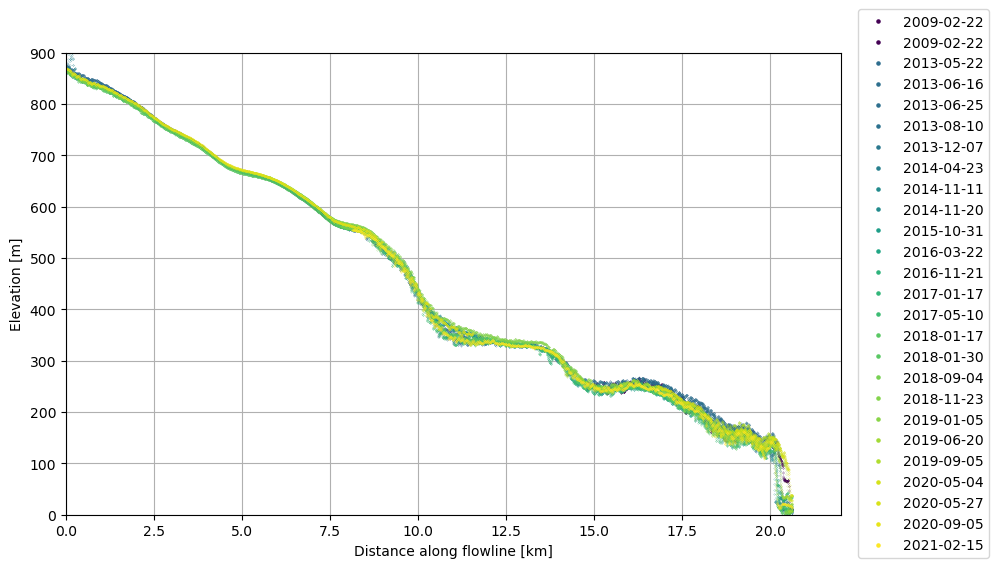

In [175]:
# -----Create colormap for dates
cl_elevs_df.reset_index(drop=True, inplace=True)
cl_elevs_df['date'] = pd.to_datetime(cl_elevs_df['date'])
cl_elevs_df.sort_values(by='date', inplace=True)
date_min, date_max = np.min(cl_elevs_df['date']), np.max(cl_elevs_df['date'])

# -----Plot
fig, ax = plt.subplots(figsize=(10,6))
for i in range(0,len(cl_elevs_df)):
    cl_elevs_date = cl_elevs_df.iloc[i]
    date = cl_elevs_date['date']
    color = plt.cm.viridis((date-date_min)/(date_max-date_min))
    ax.plot(np.divide(x, 1e3), cl_elevs_date['centerline_elevations'], '.', markersize=0.3, color=color, label=str(date)[0:10])
ax.legend(loc='center right', bbox_to_anchor=[1.0, 0.4, 0.2, 0.2], markerscale=15)
ax.set_xlim(0,22)
ax.set_ylim(0,900)
ax.grid()
ax.set_ylabel('Elevation [m]')
ax.set_xlabel('Distance along flowline [km]')
plt.show()

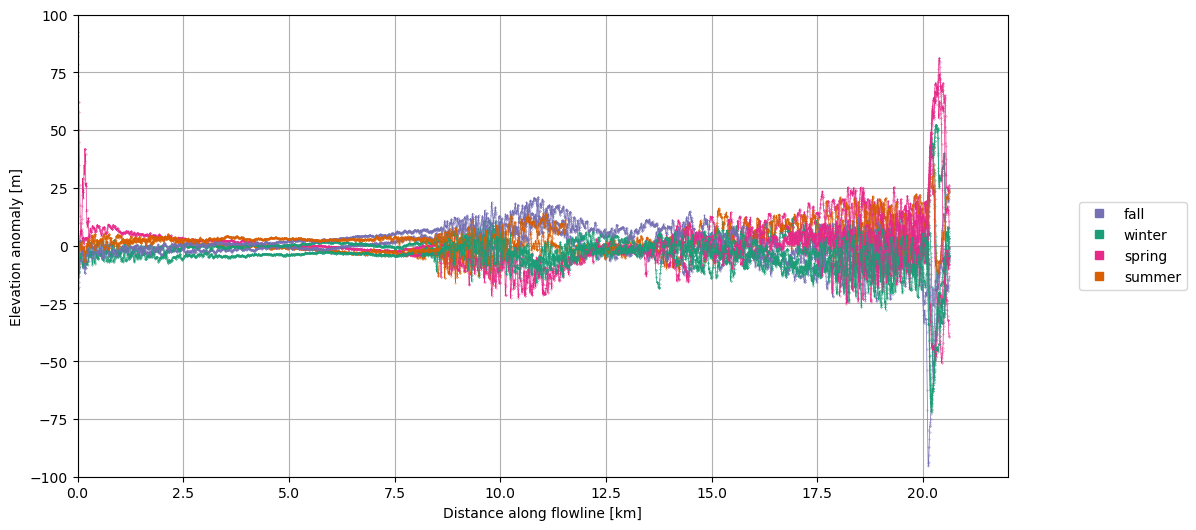

In [192]:
# -----Plot anomalies along flowline
# Calculate mean elevations along flowline
all_elevs = np.array([np.array(x) for x in cl_elevs_df['centerline_elevations']])
all_elevs_mean = np.nanmean(all_elevs, axis=0)

# set up figure
fig, ax = plt.subplots(figsize=(12,6))

# Iterate over dataframe rows
for i in range(0,len(cl_elevs_df)):
    cl_elevs_date = cl_elevs_df.iloc[i]
    date = cl_elevs_date['date']
    # Define color according to season
    month = int(str(date)[5:7])
    if (month > 3) & (month <= 6):
        season = 'spring'
        color = '#e7298a'
    elif (month > 6) & (month <= 9):
        season = 'summer'
        color = '#d95f02'
    elif (month > 9) & (month <= 12):
        season = 'fall'
        color = '#7570b3'
    else:
        season = 'winter'
        color = '#1b9e77'
    # color = plt.cm.viridis((date-date_min)/(date_max-date_min))
    ax.plot(np.divide(x, 1e3), cl_elevs_date['centerline_elevations'] - all_elevs_mean, '.-', 
            markersize=0.5, linewidth=0.5, color=color)
# plot dummy points for legend
ax.plot(-10, -10, 's', color='#7570b3', label='fall')
ax.plot(-10, -10, 's', color='#1b9e77', label='winter')
ax.plot(-10, -10, 's', color='#e7298a', label='spring')
ax.plot(-10, -10, 's', color='#d95f02', label='summer')
ax.legend(loc='center right', bbox_to_anchor=[1.0, 0.4, 0.2, 0.2])

ax.set_xlim(0,22)
ax.set_ylim(-100,100)
ax.grid()
ax.set_ylabel('Elevation anomaly [m]')
ax.set_xlabel('Distance along flowline [km]')
plt.show()

In [170]:
np.nanmean(all_elevs, axis=0)

array([878.24023 , 878.0212  , 876.5007  , ...,  61.466496,  61.436615,
        61.37099 ], dtype=float32)

In [169]:
cl_elevs_df

,dataset,date,centerline_elevations
0,ArcticDEM,2009-02-22,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,ArcticDEM,2009-02-22,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,ArcticDEM,2011-10-04,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,ArcticDEM,2013-05-22,"[872.29675, 872.5226, 872.8247, 873.0613, 873...."
4,ArcticDEM,2013-06-16,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
5,ArcticDEM,2013-06-25,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
6,ArcticDEM,2013-08-10,"[870.2479, 871.0034, 873.594, 876.31555, 877.2..."
7,ArcticDEM,2013-12-07,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
8,ArcticDEM,2014-04-23,"[974.0818, 971.88007, 958.1629, 952.67224, 939..."
9,ArcticDEM,2014-11-11,"[863.4058, 862.8909, 860.58136, 859.8738, 859...."
